# **Machine Learning on Big Data (CN7030) CRWK 23-24 Term B [60% weighting]**
# **Group ID: [Group13]**
1.   Student 1: Philip Acquaye-Mensah 2640756
2.   Student 2: Mohamed Jareer MOHAMED  ZEENAM 2596353

---

If you want to add comments on your group work, please write it here for us:


# **Initiate and Configure Spark**

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler, RobustScaler, Imputer
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression


# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("Group 13 CRWK") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()


---
# **Task 1 - Data Loading and Preprocessing (15 marks)**
---

In [3]:
#Identify the student who made a contribution and mention their name in the appropriate section of the code.

## Philip Acquaye-Mensah

# Load the compressed file as a text file
df = spark.read.csv("CourseWork_Dataset_Machine_Learning.csv", header = True)
# Display the DataFrame
df.show(20, truncate= False)

# more info
print(df.count(), df.rdd.getNumPartitions())

24/04/16 19:44:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+-------------+----------------+----------------+------------+------------+-----------+----------------+----------------+-----------+-----------+-----------+----------------+----------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+------------+-----------+-----------+--------------+--------------+----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+--------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+--------------

1048575 4


In [4]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Exclude 'Label' column from casting
columns_to_cast = [column for column in df.columns if column != 'Label']

for column in columns_to_cast:
    new_column = column.replace(' ', '_').replace('/', '_per_')
    df = df.withColumnRenamed(column, new_column).withColumn(new_column, col(new_column).cast(FloatType()))

In [5]:
# Check Multi class label
# Label is the column named Label
df.select("Label").distinct().show(20)

+--------------+
|         Label|
+--------------+
|SSH-Bruteforce|
|        Benign|
|FTP-BruteForce|
+--------------+



In [6]:
from pyspark.sql.functions import when, col

# Convert "Label" into a binary classification where "Benign" is 0 and any attack is 1
df = df.withColumn("Label_binary", when(col("Label") == "Benign", 0).otherwise(1))

# Display the updated DataFrame to verify the transformation
df.select("Label", "Label_binary").distinct().show()

+--------------+------------+
|         Label|Label_binary|
+--------------+------------+
|FTP-BruteForce|           1|
|SSH-Bruteforce|           1|
|        Benign|           0|
+--------------+------------+



In [7]:
# Drop Label column because of new binary label and Timestamp column
df = df.drop("Label","Timestamp")

# Print the schema to see the data types and structure
df.printSchema()

root
 |-- Dst_Port: float (nullable = true)
 |-- Protocol: float (nullable = true)
 |-- Flow_Duration: float (nullable = true)
 |-- Tot_Fwd_Pkts: float (nullable = true)
 |-- Tot_Bwd_Pkts: float (nullable = true)
 |-- TotLen_Fwd_Pkts: float (nullable = true)
 |-- TotLen_Bwd_Pkts: float (nullable = true)
 |-- Fwd_Pkt_Len_Max: float (nullable = true)
 |-- Fwd_Pkt_Len_Min: float (nullable = true)
 |-- Fwd_Pkt_Len_Mean: float (nullable = true)
 |-- Fwd_Pkt_Len_Std: float (nullable = true)
 |-- Bwd_Pkt_Len_Max: float (nullable = true)
 |-- Bwd_Pkt_Len_Min: float (nullable = true)
 |-- Bwd_Pkt_Len_Mean: float (nullable = true)
 |-- Bwd_Pkt_Len_Std: float (nullable = true)
 |-- Flow_Byts_per_s: float (nullable = true)
 |-- Flow_Pkts_per_s: float (nullable = true)
 |-- Flow_IAT_Mean: float (nullable = true)
 |-- Flow_IAT_Std: float (nullable = true)
 |-- Flow_IAT_Max: float (nullable = true)
 |-- Flow_IAT_Min: float (nullable = true)
 |-- Fwd_IAT_Tot: float (nullable = true)
 |-- Fwd_IAT_Mean:

In [8]:
# Check for how many attacks and benign
df.groupBy("Label_binary").count().show()

+------------+------+
|Label_binary| count|
+------------+------+
|           1|380949|
|           0|667626|
+------------+------+



In [9]:
# Check for missing values in each column
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+----------

In [10]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType


# Now, use the Imputer on the renamed column
imputer = Imputer(
    inputCols=["Flow_Byts_per_s"],
    outputCols=["Flow_Byts_s_imputed"]
).setStrategy("median")

df = imputer.fit(df).transform(df)

# Drop the 'Flow_Byts_per_s' column
df = df.drop('Flow_Byts_per_s')

# Print Schema again to check the changes
df.printSchema()

root
 |-- Dst_Port: float (nullable = true)
 |-- Protocol: float (nullable = true)
 |-- Flow_Duration: float (nullable = true)
 |-- Tot_Fwd_Pkts: float (nullable = true)
 |-- Tot_Bwd_Pkts: float (nullable = true)
 |-- TotLen_Fwd_Pkts: float (nullable = true)
 |-- TotLen_Bwd_Pkts: float (nullable = true)
 |-- Fwd_Pkt_Len_Max: float (nullable = true)
 |-- Fwd_Pkt_Len_Min: float (nullable = true)
 |-- Fwd_Pkt_Len_Mean: float (nullable = true)
 |-- Fwd_Pkt_Len_Std: float (nullable = true)
 |-- Bwd_Pkt_Len_Max: float (nullable = true)
 |-- Bwd_Pkt_Len_Min: float (nullable = true)
 |-- Bwd_Pkt_Len_Mean: float (nullable = true)
 |-- Bwd_Pkt_Len_Std: float (nullable = true)
 |-- Flow_Pkts_per_s: float (nullable = true)
 |-- Flow_IAT_Mean: float (nullable = true)
 |-- Flow_IAT_Std: float (nullable = true)
 |-- Flow_IAT_Max: float (nullable = true)
 |-- Flow_IAT_Min: float (nullable = true)
 |-- Fwd_IAT_Tot: float (nullable = true)
 |-- Fwd_IAT_Mean: float (nullable = true)
 |-- Fwd_IAT_Std: flo

In [11]:
df.describe("Flow_Pkts_per_s").show(10)

+-------+---------------+
|summary|Flow_Pkts_per_s|
+-------+---------------+
|  count|        1048575|
|   mean|       Infinity|
| stddev|            NaN|
|    min|  -0.0010297608|
|    max|       Infinity|
+-------+---------------+



In [12]:
# from pyspark.sql.functions import col, isnan
 
# # Iterate through each column in the DataFrame
# for column in df.columns:
#     # Filter and count rows with null values
#     null_count = df.filter(col(column).isNull()).count()
#     if null_count > 0:
#         print(f"Column '{column}' has {null_count} rows with null values.")
#     # Filter and count rows with NaN values
#     nan_count = df.filter(isnan(col(column))).count()
#     if nan_count > 0:
#         print(f"Column '{column}' has {nan_count} rows with NaN values.")
#     # Filter and count rows with negative values
#     negative_count = df.filter(col(column) < 0).count()
#     if negative_count > 0:
#         print(f"Column '{column}' has {negative_count} rows with negative values.")
        
#     # Filter and count rows with infinity values
#     infinity_count = df.filter(col(column) == float('inf')).count()
#     if infinity_count > 0:
#         print(f"Column '{column}' has {infinity_count} rows with infinity values.")


In [13]:
from pyspark.sql.functions import when, col

# List of columns to replace Infinity values with NaN
columns = ["Flow_Byts_s_imputed", "Flow_Pkts_per_s"]

#! Loop through each column and replace Infinity with NaN
for col_name in columns:
    df = df.withColumn(col_name, when(col(col_name) == float('inf'), float('nan')).otherwise(col(col_name)))
    
#! Replace negative values with zero for all columns in the DataFrame
for col_name in df.columns:
    df = df.withColumn(col_name, when(df[col_name] < 0, 0).otherwise(df[col_name]))


output_cols = ["Flow_Byts_s_nan_imputed", "Flow_Pkts_per_s_nan_imputed"]


#! impute nan values with mean
imputer = Imputer(
    inputCols=columns,
    outputCols=output_cols
).setStrategy("median")



df = imputer.fit(df).transform(df)

df.describe("Flow_Byts_s_nan_imputed").show()

+-------+-----------------------+
|summary|Flow_Byts_s_nan_imputed|
+-------+-----------------------+
|  count|                1048575|
|   mean|     193096.86274081515|
| stddev|     3096074.8659511684|
|    min|                    0.0|
|    max|           4.45249984E8|
+-------+-----------------------+



In [14]:
df = df.drop('Flow_Byts_s_imputed', 'Flow_Pkts_per_s')

df.show(10, truncate=False)

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+------

In [15]:
# Check for missing values again
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-------

In [16]:
# VectorAssembler and the rest of the pipeline
from pyspark.ml.feature import VectorAssembler

feature_columns = [column for column in df.columns if column not in ['Label_binary']]  # Exclude the target column

vectorAssembler = VectorAssembler(inputCols=feature_columns, outputCol="features") # VectorAssembler

data = vectorAssembler.transform(df) # Transform the DataFrame

data = data.select('features', 'Label_binary')
data.show(5)


+--------------------+------------+
|            features|Label_binary|
+--------------------+------------+
|(78,[2,3,15,16,17...|           0|
|(78,[2,3,15,16,17...|           0|
|(78,[2,3,15,16,17...|           0|
|(78,[0,1,2,3,4,5,...|           0|
|(78,[0,1,2,3,4,5,...|           0|
+--------------------+------------+
only showing top 5 rows



In [17]:
# Check again for any null or NaN values that might have been introduced
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-------

In [18]:
# Sparse Vectors
data.show(10, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                                                                                                                                                                          

In [19]:
# Extract the values from Sparse Vectors to the list format
data_select = data.select('features').limit(2).collect()
for val in data_select:
    dense_vector = val[0].toArray()
    print(dense_vector)

[0.00000000e+00 0.00000000e+00 1.12641720e+08 3.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.63208600e+07
 1.39300034e+02 5.63209600e+07 5.63207600e+07 1.12641720e+08
 5.63208600e+07 1.39300034e+02 5.63209600e+07 5.63207600e+07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.66331155e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

### StandardScaler

In [20]:
# Normalizing feature vectors
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

data = data.select("scaledFeatures", "Label_binary")
data.show(3, truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|scaledFeatures                                                                                                                                                                                                                                                                                                                                                                                                                    |Label_binary|
+-----------------------------------------------------------------------------------------------------------------------------------

In [21]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed = 42)

train_data.printSchema()

root
 |-- scaledFeatures: vector (nullable = true)
 |-- Label_binary: integer (nullable = false)



In [22]:
train_data.show(2, truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|scaledFeatures                                                                                                                                                

In [23]:
# #! Double check for any Negative, Infinity or NaN values

# # Iterate through each column in the DataFrame
# for column in df.columns:
#     # Filter rows where the column contains problematic values
#     problematic_rows = df.filter(
#         (col(column).isNull()) |   # Check for null values
#         (isnan(col(column))) |     # Check for NaN values
#         (col(column) < 0) |        # Check for negative values
#         (col(column) == float('inf'))  # Check for infinity values
#     )
    
#     # If there are any rows containing problematic values, print the column name
#     if problematic_rows.count() > 0:
#         print(f"Column '{column}' has {problematic_rows.count()} rows with problematic values.")

---
# **Task 2 - Model Selection and Implementation (25 marks)**
---


### 1st student name: Philip Acquaye-Mensah
### Model: Logistic Regression

In [24]:
lr = LogisticRegression(featuresCol = "scaledFeatures", labelCol = 'Label_binary', threshold = 0.5, regParam = 0.01)

lr_model = lr.fit(train_data)

lr_predictions_train = lr_model.transform(train_data)
lr_predictions_test = lr_model.transform(test_data)




24/04/16 19:48:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [25]:
lr_predictions_test.select("Label_binary", "prediction").show(20) 

+------------+----------+
|Label_binary|prediction|
+------------+----------+
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
|           1|       1.0|
+------------+----------+
only showing top 20 rows



In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate AUC (Area Under ROC)
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="Label_binary",
    rawPredictionCol="rawPrediction",  # ensure logistic regression is configured to provide rawPrediction
    metricName="areaUnderROC"
)
auc = auc_evaluator.evaluate(lr_predictions_test)
print("Area Under ROC = %g" % auc)
print("Area Under ROC : " , round(auc, 5)*100)

# Evaluate AUPRC (Area Under Precision-Recall Curve)
pr_evaluator = BinaryClassificationEvaluator(
    labelCol="Label_binary",
    rawPredictionCol="rawPrediction",  # ensure logistic regression is configured to provide rawPrediction
    metricName="areaUnderPR"
)
pr = pr_evaluator.evaluate(lr_predictions_test)
print("Area Under PR = %g" % auc)
print("Area Under PR = ",  round(pr, 5)*100)



Area Under ROC = 0.999922
Area Under ROC :  99.992


Area Under PR = 0.999922
Area Under PR =  99.971


In [27]:
# Common Evaluation Metrics for Binary Classification

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the evaluator for binary classification
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Label_binary', metricName='areaUnderROC')

In [28]:
# perform grid search to find the best hyperparameters for the lr model 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.5, 2.0])
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                .addGrid(lr.maxIter, [1, 5, 10])
                .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train_data)

# Use test set here so we can measure the accuracy of our model on new data
lr_predictions = cvModel.transform(test_data)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(lr_predictions)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(cvModel.bestModel.coefficients))
print("Intercept: " + str(cvModel.bestModel.intercept))

# Print the AUC for the test set
print("AUC: ", evaluator.evaluate(lr_predictions))

Coefficients: (78,[0,2,13,19,24,25,26,27,35,36,39,47,50,51,53,64,65,66,67,68,70,76,77],[-0.7377382206214159,-0.1863875478503252,-0.08028669859169527,-0.11657393557833476,-0.13480223104795694,-0.06517840137464423,-0.019978900371622164,-0.03707222987882266,0.10116820408706798,0.5694613532243299,-0.05053738142737541,0.8734253023811887,0.05722981629771208,-0.11235983046532909,-0.08028669859169527,0.4654817852470886,-0.4041570571654772,0.8357422642165253,2.6202235472795508,-0.0023888709434565455,-0.048906053423494425,-0.0946614560709771,0.28741967073055674])
Intercept: -8.13111255275168


AUC:  0.9985469860176518


In [29]:
# import numpy to check for accuracy_score, precision_score, recall_score, roc_auc_score, f1_score & confusion_matrix
# Best to use sklearn metrics

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix 

# Convert the predictions to a list
predictions = lr_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
labels = lr_predictions.select("Label_binary").rdd.flatMap(lambda x: x).collect()

# Calculate the metrics
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
roc_auc = roc_auc_score(labels, predictions)
f1 = f1_score(labels, predictions)

# Print the metrics
print("Accuracy: ", round(accuracy, 2) * 100)
print("Precision: ", round(precision, 2) * 100)
print("Recall: ", round(recall, 2) * 100)
print("ROC AUC: ", round(auc, 2) * 100)
print("F1 Score: ", round(f1, 2) * 100)

# Confusion Matrix to check misclassification

ConfusionMatrix = confusion_matrix(labels, predictions)
print("Confusion Matrix : " , ConfusionMatrix) # show the confusion matrix


Accuracy:  100.0
Precision:  99.0
Recall:  100.0
ROC AUC:  100.0
F1 Score:  100.0
Confusion Matrix :  [[199952    581]
 [     1 114295]]


24/04/16 20:24:19 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


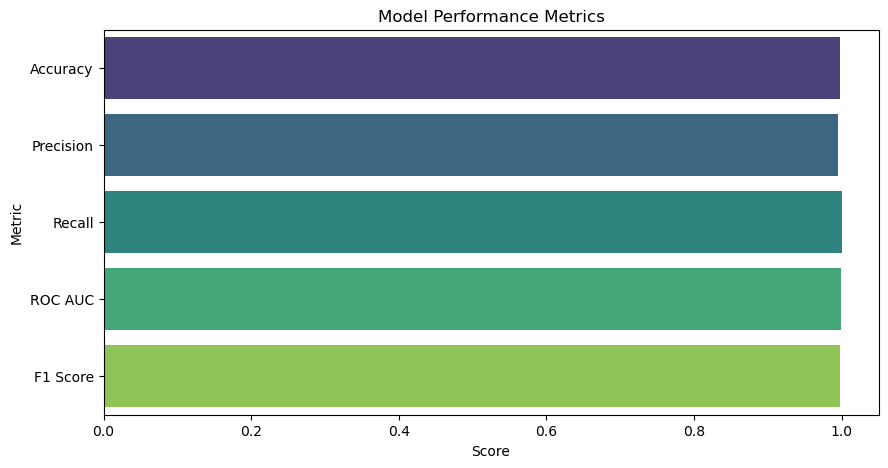

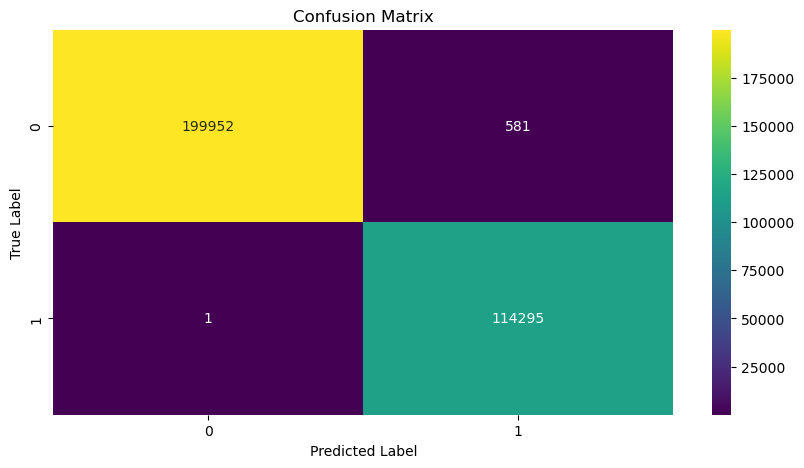

In [37]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns

# Start Spark session
spark = SparkSession.builder.appName("Model Metrics").getOrCreate()

# Define the schema for the DataFrame explicitly
schema = StructType([
    StructField("Metric", StringType(), True),
    StructField("Score", DoubleType(), True)
])

# Assuming 'metrics' contains float64 types, convert them to float (Python native type)
metrics = [float(accuracy), float(precision), float(recall), float(roc_auc), float(f1)]
metric_names = ["Accuracy", "Precision", "Recall", "ROC AUC", "F1 Score"]
results = list(zip(metric_names, metrics))

# Create DataFrame using the defined schema
results_df = spark.createDataFrame(results, schema)

# Convert to Pandas DataFrame for visualization
results_df_pd = results_df.toPandas()

# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x="Score", y="Metric", data=results_df_pd, palette="viridis")
plt.title("Model Performance Metrics")
plt.xlabel("Score")
plt.ylabel("Metric")
plt.show()

# Visualize the confusion matrix
# Note: Ensure ConfusionMatrix is properly defined, e.g., a 2D array or a properly formatted DataFrame
plt.figure(figsize=(10, 5))
sns.heatmap(ConfusionMatrix, annot=True, cmap="viridis", fmt="d")  # ConfusionMatrix needs to be defined
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



#### Apply Naive Bayes model

In [54]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

from pyspark.ml.classification import NaiveBayes

# Initialize Naive Bayes model
nb = NaiveBayes(featuresCol='scaledFeatures', labelCol='Label_binary', smoothing=0.5)  

# Fit the model to the training data
nb_model = nb.fit(train_data)

# Make predictions on the test data
nb_predictions = nb_model.transform(test_data)

In [55]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

nb_predictions.select('Label_binary', 'prediction').distinct().show()

24/04/15 13:34:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+------------+----------+
|Label_binary|prediction|
+------------+----------+
|           0|       0.0|
|           1|       1.0|
|           0|       1.0|
|           1|       0.0|
+------------+----------+



---
# **Task 3 - Model Parameter Tuning (20 marks)**
---


In [56]:
# Common Evaluation Metrics for Binary Classification

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the evaluator for binary classification
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Label_binary', metricName='areaUnderROC')

In [57]:
##1st student name: Philip Acquaye-Mensah
# add the code here


##### Grid Search results

In [74]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Naive Bayes model
nb = NaiveBayes(featuresCol='scaledFeatures', labelCol='Label_binary')

# Define a grid of hyperparameters to search over
param_grid = ParamGridBuilder() \
              .addGrid(nb.smoothing, [0.1, 0.15, 0.2, 0.27, 0.3, 0.33, 0.4, 0.48, 0.5, 0.6, 0.7, 0.72, 0.76, 0.8, 0.9, 1]) \
              .build()

# Define cross-validation
crossval = CrossValidator(estimator=nb,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=5)

# Fit the models and select the best one using cross-validation
cv_model = crossval.fit(train_data)

# Get the best model from cross-validation
best_nb_model = cv_model.bestModel

# Make predictions on the test data using the best model
nb_predictions = best_nb_model.transform(test_data)

# Evaluate the best model
auc = evaluator.evaluate(nb_predictions)

# Print the best hyperparameters and the evaluation metric
print("Best smoothing parameter:", best_nb_model.getOrDefault("smoothing"))
print("Area under ROC (AUC):", round(auc, 2)*100, "%")


Best smoothing parameter: 0.1
Area under ROC (AUC): 94.0 %


##### Random Search results

In [76]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

import random

# Perform random search manually
best_auc_roc = 0.0
best_params = None

for smoothing in random.sample([0.1, 0.15, 0.2, 0.27, 0.3, 0.33, 0.4, 0.48, 0.5, 0.6, 0.7, 0.72, 0.76, 0.8, 0.9, 1], 5):
    nb = NaiveBayes(featuresCol='scaledFeatures', labelCol='Label_binary', smoothing=smoothing)
    model = nb.fit(train_data)

    # Make predictions
    predictions_rand_search = model.transform(test_data)

    # Evaluate
    accuracy_rand_search = evaluator.evaluate(predictions_rand_search)

    # Check if the current model is the best so far
    if accuracy_rand_search > best_auc_roc:
        best_auc_roc = accuracy_rand_search
        best_params = smoothing


# Print the results
print("Best smoothing value: ", best_params)
print("Area under ROC curve:", round(best_auc_roc, 2) * 100)



Best smoothing value:  0.1
Area under ROC curve: 94.0


In [77]:
cm = nb_predictions.groupBy('Label_binary', 'prediction').count()
cm.show(cm.count(), truncate=False)

+------------+----------+------+
|Label_binary|prediction|count |
+------------+----------+------+
|0           |0.0       |177116|
|1           |1.0       |114141|
|1           |0.0       |4     |
|0           |1.0       |22636 |
+------------+----------+------+



---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

In [78]:
##1st student name: Philip Acquaye-Mensah
# add the code here


In [79]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

# Make predictions
predictionAndTarget = nb_model.transform(test_data).select("Label_binary", "prediction")

predictionAndTargetNumpy = np.array((predictionAndTarget.collect()))

acc = accuracy_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
f1 = f1_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
precision = precision_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
recall = recall_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
auc = roc_auc_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])

# print the evaluation metrics
print("Accuracy:", round(acc, 2) * 100)
print("f1_score:", round(f1, 2) * 100)
print("precision:", round(precision, 2) * 100)
print("recall:", round(recall, 2) * 100)
print("AUC:", round(auc, 2) * 100)

Accuracy: 93.0
f1_score: 91.0
precision: 83.0
recall: 100.0
AUC: 94.0


#### Confusion Matrix

In [80]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

cm = nb_predictions.groupBy('Label_binary', 'prediction').count()
cm.show(cm.count(), truncate=False)

+------------+----------+------+
|Label_binary|prediction|count |
+------------+----------+------+
|0           |0.0       |177116|
|1           |1.0       |114141|
|1           |0.0       |4     |
|0           |1.0       |22636 |
+------------+----------+------+



In [81]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

#  Check the Missclassification rate
confusion_matrix = cm.groupBy('Label_binary').pivot('prediction').sum('count').na.fill(0)
confusion_matrix.show()

+------------+------+------+
|Label_binary|   0.0|   1.0|
+------------+------+------+
|           1|     4|114141|
|           0|177116| 22636|
+------------+------+------+



---
# **Task 5 - Results Visualization or Printing (5 marks)**
---

In [82]:
##1st student name: Philip Acquaye-Mensah
# add the code here


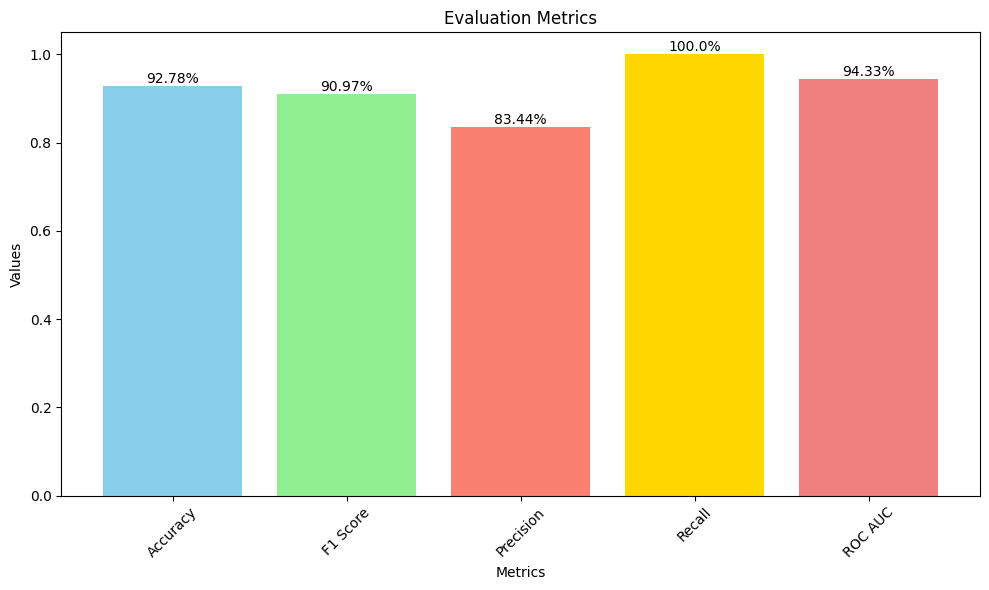

In [83]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

import matplotlib.pyplot as plt

# Define evaluation metrics and values
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC']
values = [acc, f1, precision, recall, auc]

# Define colors for the bars
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral']

# Create a bar plot with custom styling
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors)

# Add labels and title
plt.title('Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')

# Add text labels on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),  f'{round(value * 100, 2)}%',
             ha='center', va='bottom')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


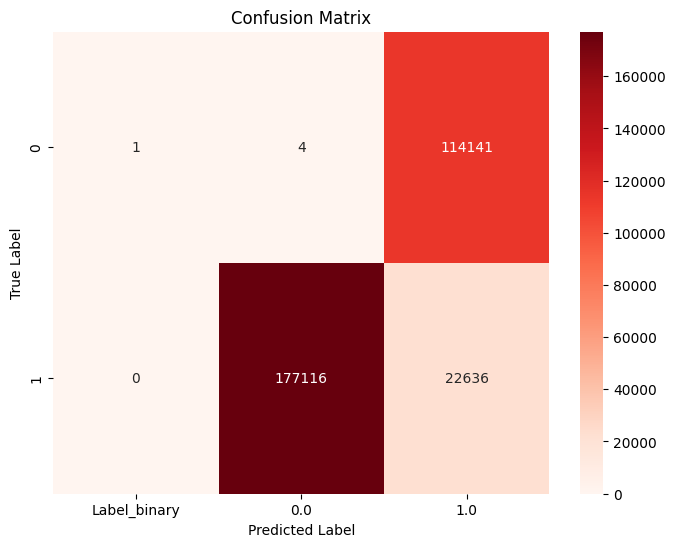

In [84]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

import seaborn as sns

# Convert confusion matrix to pandas DataFrame
confusion_matrix_pd = confusion_matrix.toPandas()

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pd, annot=True, cmap='Reds', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


---
# **Task 6 - LSEP Considerations (5 marks)**
---

# Student 1: **Type the chosen issue**

add contribution here ...

# Student 2: **Type the chosen issue**

add contribution here ...

---

# **Task 7 - Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [ ]:
# install nbconvert (if facing the conversion error)
#!pip3 install nbconvert

In [ ]:
# convert ipynb to html and submit this HTML file
#!jupyter nbconvert --to html Your_Group_ID_CRWK_CN7030.ipynb

[NbConvertApp] WARNING | pattern 'Your_Group_ID_CRWK_CN7030.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]